# CNN trigger classifier

In this notebook we will investigate the use of CNN models for classifying detector images as triggered event.

In [1]:
# Python 2-3 compatibility
from __future__ import print_function
from __future__ import division

# System imports
import sys
import os
import multiprocessing as mp
from functools import partial

# External imports
import numpy as np
import pandas as pd

# Local imports
from data import process_files, select_barrel_hits, check_data_consistency, bin_barrel_hits

# Plotting
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
# Training concurrency
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [3]:
from keras import layers, models

import keras.backend as K
K.set_image_data_format('channels_first')

from drawing import draw_train_history

Using TensorFlow backend.


## Load the data

In [4]:
input_dir = '/bigdata/shared/HEP.TrkX/volimages_001'

In [5]:
vols = [0, 1, 2]

bins = np.load(os.path.join(input_dir, 'bins.npy')).tolist()
ranges = np.load(os.path.join(input_dir, 'ranges.npy')).tolist()

train_hists = [np.load(os.path.join(input_dir, 'train_v%i.npy'%iv), mmap_mode='r')
               for iv in vols]
test_hists = [np.load(os.path.join(input_dir, 'test_v%i.npy'%iv), mmap_mode='r')
              for iv in vols]

train_labels = np.load(os.path.join(input_dir, 'train_labels.npy'))
test_labels = np.load(os.path.join(input_dir, 'test_labels.npy'))

## CNN classifier model

Now we define the model which will classify events according to the trigger decision.

In [6]:
def build_cnn_model(input_shapes):

    # Inputs for each detector volume
    in0 = layers.Input(shape=input_shapes[0])
    in1 = layers.Input(shape=input_shapes[1])
    in2 = layers.Input(shape=input_shapes[2])

    # CNN module for volume 0
    conv_args = dict(padding='same', activation='relu')
    h0 = layers.Conv2D(8, (3, 3), **conv_args)(in0)
    h0 = layers.MaxPool2D((2, 2))(h0)
    h0 = layers.Conv2D(8, (3, 3), **conv_args)(h0)
    h0 = layers.MaxPool2D((2, 2))(h0)
    h0 = layers.Conv2D(8, (3, 3), **conv_args)(h0)
    h0 = layers.MaxPool2D((4, 4))(h0)
    h0 = layers.Conv2D(8, (3, 3), **conv_args)(h0)
    h0 = layers.MaxPool2D((4, 4))(h0)
    h0 = layers.Flatten()(h0)

    # CNN module for volume 1
    h1 = layers.Conv2D(8, (3, 3), **conv_args)(in1)
    h1 = layers.MaxPool2D((2, 2))(h1)
    h1 = layers.Conv2D(8, (3, 3), **conv_args)(h1)
    h1 = layers.MaxPool2D((2, 2))(h1)
    h1 = layers.Conv2D(8, (3, 3), **conv_args)(h1)
    h1 = layers.MaxPool2D((4, 4))(h1)
    h1 = layers.Conv2D(8, (3, 3), **conv_args)(h1)
    h1 = layers.MaxPool2D((4, 4))(h1)
    h1 = layers.Flatten()(h1)

    # CNN module for volume 2
    h2 = layers.Conv2D(8, (3, 3), **conv_args)(in2)
    h2 = layers.MaxPool2D((2, 2))(h2)
    h2 = layers.Conv2D(8, (3, 3), **conv_args)(h2)
    h2 = layers.MaxPool2D((2, 2))(h2)
    h2 = layers.Conv2D(8, (3, 3), **conv_args)(h2)
    h2 = layers.MaxPool2D((4, 2))(h2)
    h2 = layers.Conv2D(8, (3, 3), **conv_args)(h2)
    h2 = layers.MaxPool2D((4, 2))(h2)
    h2 = layers.Flatten()(h2)

    # Combine the modules and final layers
    hout = layers.concatenate([h0, h1, h2], axis=1)
    hout = layers.Dense(16, activation='relu')(hout)
    hout = layers.Dense(1, activation='sigmoid')(hout)

    # Compile the model
    model = models.Model(inputs=[in0, in1, in2], outputs=hout)
    model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

## Train the model

In [7]:
# Training config
batch_size = 32
n_epochs = 10
val_frac = 0.2

In [8]:
model = build_cnn_model(bins)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 4, 128, 128)   0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 4, 128, 128)   0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 2, 128, 21)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 8, 128, 128)   296         input_1[0][0]                    
___________________________________________________________________________________________

In [ ]:
history = model.fit(train_hists, train_labels, batch_size=batch_size,
                    epochs=n_epochs, validation_split=val_frac, shuffle=False)

Train on 68133 samples, validate on 17034 samples
Epoch 1/10
68133/68133 [==============================] - 291s - loss: 0.3539 - acc: 0.8362 - val_loss: 0.3466 - val_acc: 0.8430
Epoch 2/10
68133/68133 [==============================] - 220s - loss: 0.3190 - acc: 0.8537 - val_loss: 0.3346 - val_acc: 0.8485
Epoch 3/10
68133/68133 [==============================] - 221s - loss: 0.3032 - acc: 0.8614 - val_loss: 0.3099 - val_acc: 0.8614
Epoch 4/10
68133/68133 [==============================] - 221s - loss: 0.2903 - acc: 0.8692 - val_loss: 0.2956 - val_acc: 0.8706
Epoch 5/10
68133/68133 [==============================] - 221s - loss: 0.2793 - acc: 0.8742 - val_loss: 0.2855 - val_acc: 0.8713
Epoch 6/10
68133/68133 [==============================] - 221s - loss: 0.2702 - acc: 0.8784 - val_loss: 0.2859 - val_acc: 0.8700
Epoch 7/10
68133/68133 [==============================] - 221s - loss: 0.2542 - acc: 0.8872 - val_loss: 0.2899 - val_acc: 0.8730
Epoch 9/10
68133/68133 [=======================

<IPython.core.display.Javascript object>


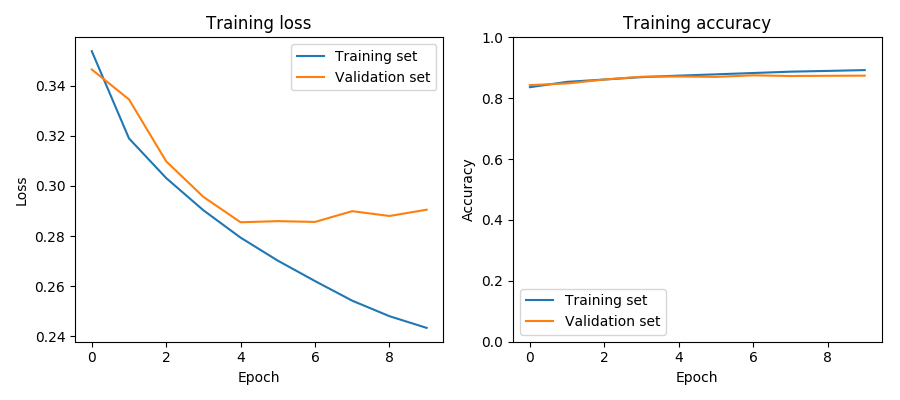

In [11]:
fig = draw_train_history(history, figsize=(9,4))

## Evaluate on the test set

In [18]:
import sklearn.metrics

In [15]:
test_pred = model.predict(test_hists, batch_size=batch_size)

In [26]:
fpr, tpr, _ = sklearn.metrics.roc_curve(test_labels, test_pred.squeeze())

<IPython.core.display.Javascript object>


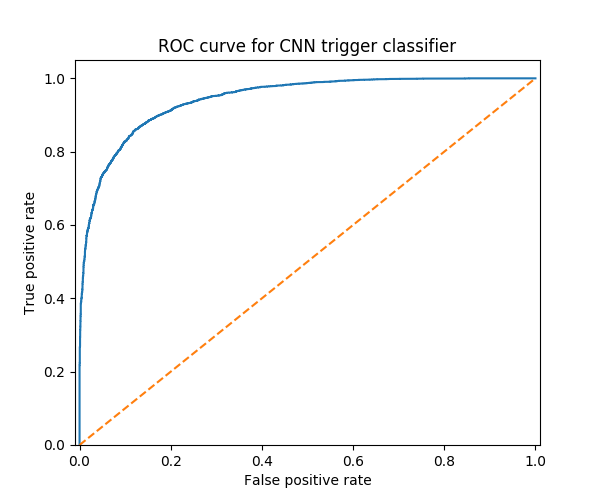

In [35]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(ymin=0)
plt.xlim(xmin=-0.01, xmax=1.01)
plt.title('ROC curve for CNN trigger classifier')

## Discussion

The model performance here is already semi-reasonable, but there are issues:
- it overfits somewhat. I should investigate regularization methods here.
- the samples are all from the same inherent distribution. My arbitrary choice of cut might not be sufficiently meaningful. E.g., it might just be selecting high-activity events because they are more likely to have more high-pt tracks from the distribution.
  - it would be better to have distinct samples: one with definitely high-pt tracks, and one with soft tracks only.
- the model has very few parameters which further suggests it might be learning something stupid and not my intended task.
- I need to look at sample images to see what 2GeV tracks look like.